In [1]:
import requests
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import ruptures as rpt
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Import arps decline and discounted cash flow functions
# Will change in the future to a python library
fcst_url = 'https://raw.githubusercontent.com/jshumway0475/Petroleum/main/prod_fcst_functions.py'
prod_data_url = r'https://raw.githubusercontent.com/jshumway0475/Petroleum/main/prod_data.py'
response1 = requests.get(fcst_url)
exec(response1.text)

In [6]:
# type: ignore
# Prepare SQL statement
statement = '''
SELECT		W.Property_ID, F.Zone, P.Date, P.Oil, P.Gas
FROM		dbo.Production P
INNER JOIN	(SELECT Property_ID, Formation_ID, First_Prod_Date FROM dbo.Wells) W ON P.Property_ID = W.Property_ID
INNER JOIN	(SELECT Formation_ID, Zone FROM dbo.Formation) F ON W.Formation_ID = F.Formation_ID
WHERE		F.Zone = 'MRMC'
ORDER BY	W.Property_ID, P.Date
'''

In [7]:
# Bring in production data from SQL
def prod_data(sql, db_name = 'SCST_Wells', server_name = 'DESKTOP-A3I0ATB'):
    conn_stmt = f'DRIVER={{SQL Server}};SERVER={server_name};DATABASE={db_name};Trusted_Connection=yes'
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={conn_stmt}")
    prod_df = pd.read_sql_query(sql, engine)
    prod_df = prod_df.melt(id_vars=['Property_ID', 'Zone', 'Date'], var_name='phase', value_name='monthly_production')
    prod_df = prod_df[(prod_df['monthly_production'] > 0) & (prod_df['monthly_production'].notnull())]
    prod_df = prod_df.sort_values(by=['Property_ID', 'Date'])
    prod_df['monthly_production'] = prod_df['monthly_production'].astype(float)
    prod_df['Date'] = pd.to_datetime(prod_df['Date'], format='%Y-%m-%d')
    prod_df['day'] = prod_df.Date.dt.day
    prod_df['daily_production'] = prod_df['monthly_production'] / prod_df['day']
    prod_df.drop(['day'], axis=1, inplace=True)
    return prod_df

In [8]:
# Create dataframe with production data and another to create well lists for fitting
prod_df = prod_data(statement)
prod_pivot_df = prod_df.groupby(['Property_ID', 'phase']).agg({'monthly_production': 'count'}).reset_index()

In [9]:
prod_df.to_csv('mrmc_prod_data.csv')

In [6]:
# Detect change points in production data
def detect_changepoints(df, column, pen):
    # Create a new column for the segment numbers
    df['segment'] = 0
    
    # Get the list of unique properties
    properties = df['Property_ID'].unique()

    for property in properties:
        # Filter the dataframe for the current property
        property_df = df[df['Property_ID'] == property]

        # Sort by date
        property_df = property_df.sort_values('Date')

        # Extract the column values as a numpy array
        signal = property_df[column].values

        # Perform the change point detection
        try:
            algo = rpt.Pelt(model="rbf", min_size=6).fit(signal)
            result = algo.predict(pen=pen)
        except rpt.exceptions.BadSegmentationParameters:
            # Handle exception
            result = []

        # Assign segment numbers
        segment_number = 1
        for i in range(len(property_df)):
            if i in result:
                segment_number += 1
            df.loc[property_df.index[i], 'segment'] = segment_number

    return df

In [7]:
# Apply the function to the dataframe
prod_df_oil = prod_df[prod_df['phase'] == 'Oil'].groupby('Property_ID').apply(detect_changepoints, 'daily_production', 10)
prod_df_gas = prod_df[prod_df['phase'] == 'Gas'].groupby('Property_ID').apply(detect_changepoints, 'daily_production', 10)
prod_df = pd.concat([prod_df_oil, prod_df_gas])
prod_df.reset_index(inplace=True, drop=True)

In [8]:
# Smooth daily_oil and daily_gas
def smooth_group_svr(uid, column_name):
    # Reshape index array to 2D for Scikit-Learn
    X = uid.index.values.reshape(-1, 1)
    
    # Rescale X to have zero mean and unit variance
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    # Reshape target array to 1D for Scikit-Learn
    y = uid[column_name].values

    # If group has less than 2 unique values, use original data as smoothed data
    if len(np.unique(y)) < 2:
        uid['smoothed_' + column_name] = uid[column_name]
    else:
        # Fit the SVR model
        try:
            model = SVR(kernel='rbf', C=10000.0, epsilon=0.001, gamma='scale')
            model.fit(X_scaled, y)
            uid['smoothed_' + column_name] = model.predict(X_scaled)
        except Exception as e:
            print(f"Exception occurred: {e}")
            uid['smoothed_' + column_name] = uid[column_name]
    return uid


# Create an empty list to store the results
results = []

# Apply the function to each group and add the result to the list
for name, group in prod_df.groupby(['Property_ID', 'phase', 'segment']):
    result = smooth_group_svr(group, 'daily_production')
    results.append(result)

# Concatenate all the results into a single DataFrame
prod_df = pd.concat(results)

# Reset the index
prod_df.reset_index(inplace=True, drop=True)

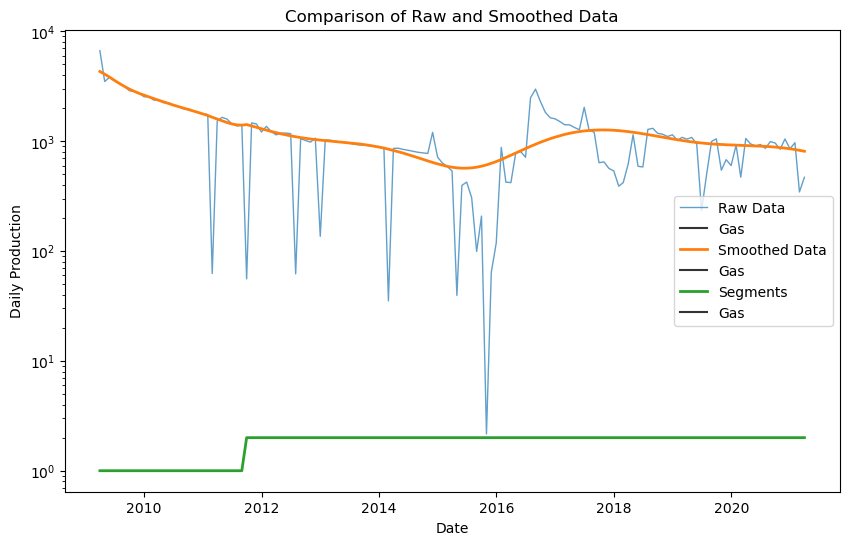

In [9]:
# Plotting the raw and smoothed data
# api_no = list(prod_pivot_df['Property_ID'].values)[0:1]
api_no = ['3501123254']
phase = 'Gas'

for w in api_no:
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=prod_df[(prod_df['Property_ID'] == w) & (prod_df['phase'] == phase)], x='Date', y='daily_production', style='phase', linewidth=1, alpha=0.7, label='Raw Data')
    sns.lineplot(data=prod_df[(prod_df['Property_ID'] == w) & (prod_df['phase'] == phase)], x='Date', y='smoothed_daily_production', style='phase', linewidth=2, label='Smoothed Data')
    sns.lineplot(data=prod_df[(prod_df['Property_ID'] == w) & (prod_df['phase'] == phase)], x='Date', y='segment', style='phase', linewidth=2, label='Segments')
    plt.xlabel('Date')
    plt.ylabel('Daily Production')
    plt.title('Comparison of Raw and Smoothed Data')
    ax.set_yscale('log')
    plt.legend()
    plt.show()

In [10]:
# Define parameters
smoothing = 'raw'
fit_segment = 'last'
b_dict = {'min': 0.5, 'guess': 0.9, 'max': 1.2}
def_dict = {'Oil': 0.08, 'Gas': 0.06}
dei_dict1 = {'guess': 0.5, 'max': 0.99}
min_q_dict = {'Oil': 1.0, 'Gas': 10.0}
smoothing_col_dict = {'raw': 'daily_production', 'smooth': 'smoothed_daily_production'}
param_df_cols = ['Property_ID', 'phase', 'fit_months', 'fit_type', 'data_type', 'fit_segment', 'Start_Date', 'Q_guess', 'Q3', 'Dei', 'b-factor', 'R_squared', 'RMSE', 'MAE']

In [11]:
# Add a column for the dei_dict
prod_pivot_df['Dei_dict'] = pd.Series([dei_dict1] * len(prod_pivot_df), index=prod_pivot_df.index)

In [12]:
# type: ignore
def fit_arps_curve(property_id, phase, b_dict, dei_dict, def_dict, min_q_dict, prod_df, smoothing_col_dict, smoothing='raw', fit_segment='all'):
    def arps_fit(t, Qi, Dei, b, Def):
        return varps_decline(1, 1, Qi, Dei, Def, b, t, 0, 0)[3]

    def calc_goodness_of_fit(q_act, q_pred):
        r_squared = scipy.stats.pearsonr(q_act, q_pred)[0] ** 2
        rmse = np.sqrt(np.mean((q_act - q_pred) ** 2))
        mae = np.mean(np.abs(q_act - q_pred))
        return r_squared, rmse, mae
    
    def dict_coalesce(dei_dict, def_dict):
        return dei_dict.get('min', def_dict[phase])

    df = prod_df[(prod_df['Property_ID'] == property_id) & (prod_df[smoothing_col_dict[smoothing]] > 0)]
    if fit_segment == 'first':
        df = df[df['segment'] == df['segment'].min()]
    elif fit_segment == 'last':
        df = df[df['segment'] == df['segment'].max()]
    arr_length = len(df)
    t_act = df['Date'].rank(method='min', ascending=True).values
    q_act = df[smoothing_col_dict[smoothing]].values
    start_date = df['Date'].min()
    Qi_guess = np.max(q_act, initial=0)
    Dei_init = dei_dict['guess']
    Dei_min = dict_coalesce(dei_dict, def_dict)
    Dei_max = dei_dict['max']

    if (Qi_guess < min_q_dict[phase]) | (arr_length < 3.0):
        return [property_id, phase, arr_length, 'auto_fit_3', smoothing, fit_segment, start_date, Qi_guess, Qi_guess, max(Dei_init, def_dict[phase]), b_dict['guess'], np.nan, np.nan, np.nan]
    else:
        try:
            bounds = ((Qi_guess*0.9, Dei_min, b_dict['min']), (Qi_guess, Dei_max, b_dict['max']))
            popt, pcov = curve_fit(lambda t, Qi, Dei, b: arps_fit(t, Qi, Dei, b, def_dict[phase]), t_act, q_act, p0=[Qi_guess, Dei_init, b_dict['guess']], bounds=bounds, maxfev=3000)
            qi_fit, Dei_fit, b_fit = popt
            # Fitting the curve
            q_pred = arps_fit(t_act, qi_fit, Dei_fit, b_fit, def_dict[phase])
            r_squared, rmse, mae = calc_goodness_of_fit(q_act, q_pred)
            return [property_id, phase, arr_length, 'auto_fit_1', smoothing, fit_segment, start_date, Qi_guess, qi_fit, Dei_fit, b_fit, r_squared, rmse, mae]
        except:
            try:
                bounds = ((Dei_min, Dei_max))
                popt, pcov = curve_fit(lambda t, Dei: arps_fit(t, Qi_guess, Dei, b_dict['guess'], def_dict[phase]), t_act, q_act, p0=[Dei_init], bounds=bounds, maxfev=3000)
                Dei_fit = popt[0]
                # Fitting the curve
                q_pred = arps_fit(t_act, Qi_guess, Dei_fit, b_dict['guess'], def_dict[phase])
                r_squared, rmse, mae = calc_goodness_of_fit(q_act, q_pred)
                return [property_id, phase, arr_length, 'auto_fit_2', smoothing, fit_segment, start_date, Qi_guess, Qi_guess, Dei_fit, b_dict['guess'], r_squared, rmse, mae]
            except:
                return [property_id, phase, arr_length, 'auto_fit_3', smoothing, fit_segment, start_date, Qi_guess, Qi_guess, max(Dei_init, def_dict[phase]), b_dict['guess'], np.nan, np.nan, np.nan]

In [13]:
# Create wrapper function for fit_arps_curve
def fit_arps_curve_wrapper(row, prod_df, smoothing='raw', fit_segment='all'):
    return fit_arps_curve(
        row['Property_ID'],
        row['phase'],
        b_dict,
        row['Dei_dict'],
        def_dict,
        min_q_dict,
        prod_df,
        smoothing_col_dict,
        smoothing,
        fit_segment
    )

In [14]:
# Fit curves to wells in prod_df
param_df = prod_pivot_df[['Property_ID', 'phase', 'Dei_dict']].apply(lambda row: fit_arps_curve_wrapper(row, prod_df, smoothing, fit_segment), axis=1, result_type='expand')
param_df.columns = param_df_cols

In [15]:
min_r2 = 0.7
train_df = param_df[param_df['R_squared'] > min_r2]

In [16]:
# Clean up columns for regression
train_df = train_df.drop(['fit_months', 'fit_type', 'data_type', 'fit_segment', 'Q_guess','R_squared', 'RMSE', 'MAE'], axis=1)

# Convert all other columns to numeric data types
num_cols = train_df.columns.difference(['phase', 'Dei'])
train_df[num_cols] = train_df[num_cols].apply(pd.to_numeric)

# Add dummy variables to train_df
train_df = pd.get_dummies(train_df, columns=['phase'])

# Convert the dummy columns to integers
dummy_cols = ['phase_Gas', 'phase_Oil']
train_df[dummy_cols] = train_df[dummy_cols].astype(int)

In [17]:
# Prepare data for regression
X, y = train_df.drop(['Dei', 'Property_ID'], axis=1), train_df['Dei']

# Standardize the predictors
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Add a constant to the predictors
X_std = sm.add_constant(X_std)

In [18]:
# Define the Ridge model
model = sm.OLS(y, X_std)

# Specify L2 (Ridge) regularization
ridge_results = model.fit_regularized(method='elastic_net', alpha=1.0, L1_wt=0)

# Unregularized fit for CI calculation
model_ols = sm.OLS(y, X_std)
ols_results = model_ols.fit()

print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Dei   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     50.33
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           6.56e-37
Time:                        11:24:47   Log-Likelihood:                 373.86
No. Observations:                 654   AIC:                            -737.7
Df Residuals:                     649   BIC:                            -715.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2370      0.005     44.194      0.0

In [19]:
# Drop unnecessary columns
refit_df = param_df.drop(['fit_months', 'fit_type', 'data_type', 'fit_segment', 'Q_guess','R_squared', 'RMSE', 'MAE'], axis=1)

# Convert all other columns to numeric data types
refit_df[num_cols] = refit_df[num_cols].apply(pd.to_numeric)

# Add dummy variables to param_df
refit_df = pd.get_dummies(refit_df, columns=['phase'])

# Convert the dummy columns to integers
refit_df[dummy_cols] = refit_df[dummy_cols].astype(int)

# Ensure Property_ID is a string
refit_df['Property_ID'] = refit_df['Property_ID'].astype(str)

In [20]:
# Prepare data for prediction
refit_X = refit_df.drop(['Dei', 'Property_ID'], axis=1)

# Standardize the predictors with the same scaler used for training
refit_X_std = scaler.transform(refit_X)

# Add a constant to the predictors
refit_X_std = sm.add_constant(refit_X_std)

# Get predictions
predictions = ridge_results.predict(refit_X_std)

# Get confidence intervals from the unregularized fit
predictions_ols = ols_results.get_prediction(refit_X_std)
summary_frame = predictions_ols.summary_frame(alpha=0.05)  # 95% confidence intervals

In [21]:
# Add predicted Dei values and confidence intervals to param_df
refit_df['predicted_Dei'] = summary_frame['mean'].clip(upper=0.99)
refit_df['Dei_lower_ci'] = summary_frame['obs_ci_lower']
refit_df['Dei_upper_ci'] = summary_frame['obs_ci_upper'].clip(upper=0.99)

# Restore the 'Phase' column and ensure the minimum value for 'Dei_lower_ci' is the same as the phase Def
refit_df['phase'] = np.where(refit_df['phase_Gas'] == 1, 'Gas', 'Oil')
refit_df = refit_df.drop(['phase_Gas', 'phase_Oil'], axis=1)
refit_df['phase_value'] = refit_df['phase'].map(def_dict)
refit_df['Dei_lower_ci'] = refit_df.apply(lambda row: max(row['Dei_lower_ci'], row['phase_value']), axis=1)
refit_df = refit_df.drop(['phase_value'], axis=1)

# Create a column that is a dictionary of the predicted Dei and confidence intervals
refit_df['Dei_dict'] = refit_df.apply(lambda row: {'guess': row['predicted_Dei'], 'min': row['Dei_lower_ci'], 'max': row['Dei_upper_ci']}, axis=1)

In [22]:
# Make a second pass of fitting based on the first pass results
param2_df = refit_df[['Property_ID', 'phase', 'Dei_dict']].apply(lambda row: fit_arps_curve_wrapper(row, prod_df, smoothing, fit_segment), axis=1, result_type='expand')
param2_df.columns = param_df_cols

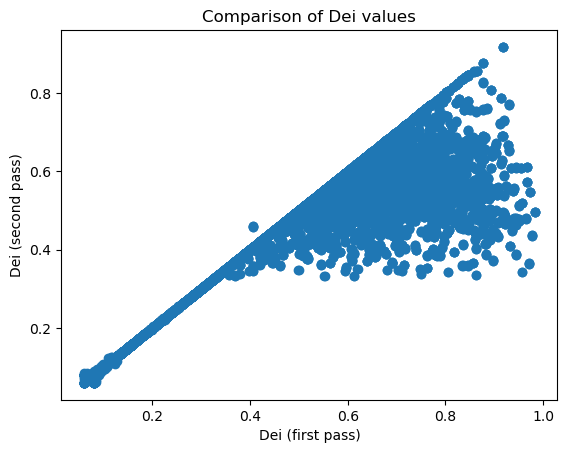

In [23]:
param_df_joined = param_df.set_index('Property_ID').join(param2_df.set_index('Property_ID'), lsuffix='_1', rsuffix='_2').reset_index()
param_df_joined = param_df_joined[param_df_joined[['Property_ID', 'Dei_1', 'Dei_2']].notnull().all(axis=1)]
param_df_joined = param_df_joined[(param_df_joined['fit_type_1'] == 'auto_fit_1') & (param_df_joined['fit_type_2'] == 'auto_fit_1')]

# Extract the R_squared columns from the dataframes
dei1 = param_df_joined['Dei_1']
dei2 = param_df_joined['Dei_2']

# Create the scatter plot
plt.scatter(dei1, dei2)

# Add axis labels and a title
plt.xlabel('Dei (first pass)')
plt.ylabel('Dei (second pass)')
plt.title('Comparison of Dei values')

# Display the plot
plt.show()

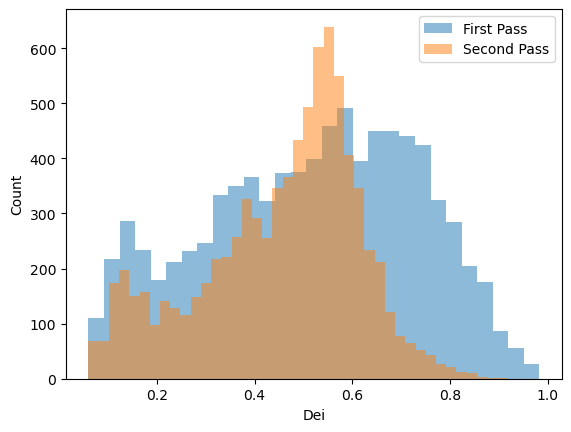

In [24]:
# Plot the Dei values from param_df and param2_df as semi-transparent kde plots
sns.histplot(data=param_df[param_df['fit_type'] == 'auto_fit_1'], x='Dei', fill=True, alpha=0.5, label='First Pass', linewidth=0)
sns.histplot(data=param2_df[param2_df['fit_type'] == 'auto_fit_1'], x='Dei', fill=True, alpha=0.5, label='Second Pass', linewidth=0)

# Add a legend
plt.legend()

# Show the plot
plt.show()

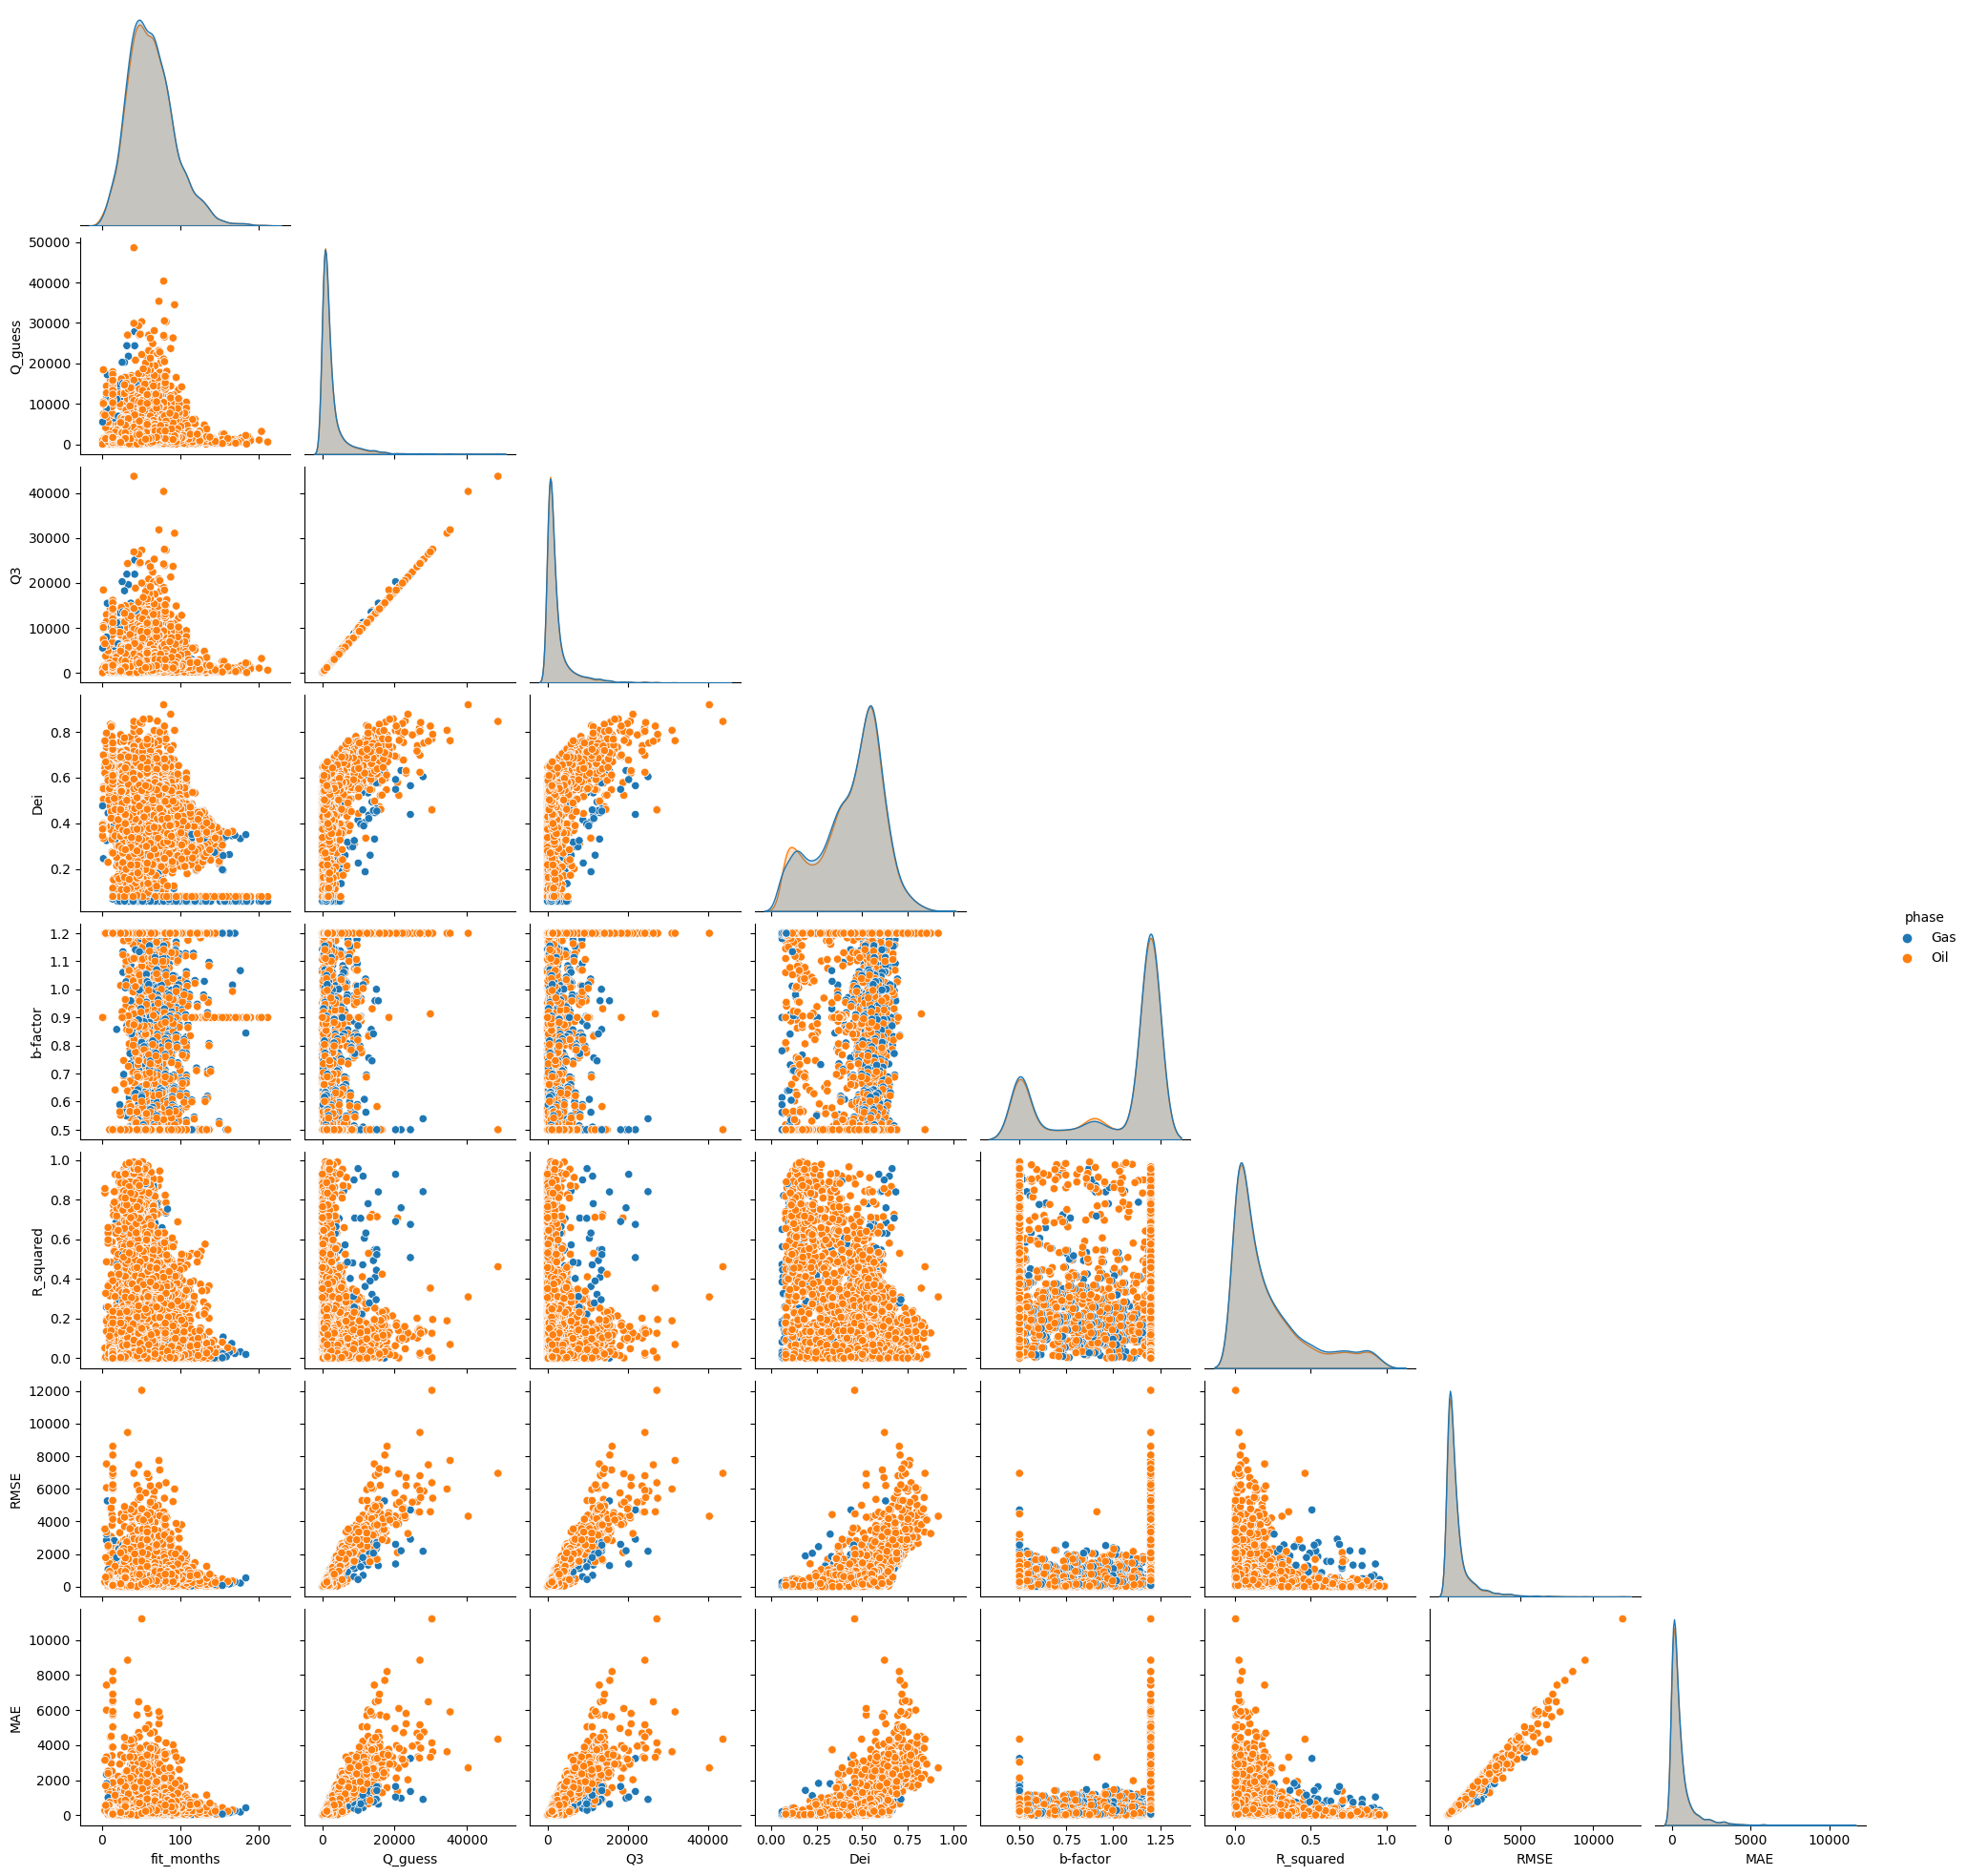

In [25]:
sns.pairplot(param2_df, hue='phase', diag_kind='kde', corner=True)

In [26]:
param2_df[param2_df['Dei'] < 0.06]

,Property_ID,phase,fit_months,fit_type,data_type,fit_segment,Start_Date,Q_guess,Q3,Dei,b-factor,R_squared,RMSE,MAE
